In [9]:
#https://www.kaggle.com/code/vinuthavikas/chest-cancer-ct-scan-detector/edit
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Dense,MaxPooling2D,Flatten,BatchNormalization,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import preprocess_input
import matplotlib.pyplot as plt
import cv2 as cv
# from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix,classification_report
# from keras.utils import to_categorical

import os



In [10]:
train_path_str = 'C:/Users/Vinutha/Downloads/archive (7)/Data/train'


In [11]:
val_path_str = 'C:/Users/Vinutha/Downloads/archive (7)/Data/valid'
test_path_str = 'C:/Users/Vinutha/Downloads/archive (7)/Data/test'

In [12]:
test_classes = os.listdir(test_path_str)

In [13]:
input_shape = (224,224,3)
num_classes = 4

trainGenertor = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 10,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    shear_range = 0.2,
    zoom_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    dtype = 'float32'
)
valGenertor = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    dtype = 'float32'
)

testGenertor = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    dtype = 'float32'
)


In [14]:
train_data = trainGenertor.flow_from_directory(
    train_path_str,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical'
)

val_data = valGenertor.flow_from_directory(
    val_path_str,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical'
)

test_data = testGenertor.flow_from_directory(
    test_path_str,
    target_size = (224,224),
    batch_size = 16,
    class_mode = 'categorical',
    shuffle = False
)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [15]:
VGG16_model = VGG16(
    include_top = False,
    weights="imagenet",
    input_shape = input_shape
)
for layer in VGG16_model.layers :
  layer.trainable = False

In [ ]:
#from keras.src.metrics.confusion_metrics import activations
model = Sequential()
model.add(VGG16_model)
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(1024,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(512,activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(256,activation = 'relu'))
model.add(Dense(128,activation = 'relu'))
model.add(Dense(num_classes,activation = 'softmax'))
model.summary()

In [ ]:
model.compile(
    optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy']
)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint('model.h5',save_best_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

In [ ]:
results = model.fit(train_data,validation_data=val_data,epochs=100,verbose = 1)

Epoch 1/100
39/39 [==============================] - 894s 23s/step - loss: 0.2320 - accuracy: 0.9217 - val_loss: 0.5099 - val_accuracy: 0.8472
Epoch 2/100
39/39 [==============================] - 146s 4s/step - loss: 0.1804 - accuracy: 0.9299 - val_loss: 0.5434 - val_accuracy: 0.8333
Epoch 3/100
39/39 [==============================] - 147s 4s/step - loss: 0.1159 - accuracy: 0.9527 - val_loss: 0.7434 - val_accuracy: 0.8333
Epoch 4/100
39/39 [==============================] - 149s 4s/step - loss: 0.2078 - accuracy: 0.9315 - val_loss: 0.4855 - val_accuracy: 0.8750
Epoch 5/100
39/39 [==============================] - 147s 4s/step - loss: 0.1796 - accuracy: 0.9347 - val_loss: 0.5703 - val_accuracy: 0.8611
Epoch 6/100
39/39 [==============================] - 144s 4s/step - loss: 0.2351 - accuracy: 0.9250 - val_loss: 0.4070 - val_accuracy: 0.8750
Epoch 7/100
39/39 [==============================] - 147s 4s/step - loss: 0.1887 - accuracy: 0.9413 - val_loss: 0.5200 - val_accuracy: 0.8611
Epoch

In [ ]:
loss, acc = model.evaluate(test_data,verbose = 1)

In [21]:
import seaborn as sns
predictions_prob = model.predict(test_data)
predictions = np.argmax(predictions_prob , axis = 1)
true_label = test_data.classes
report = classification_report(true_label,predictions)
print(report)


              precision    recall  f1-score   support

           0       0.93      0.79      0.86       120
           1       0.71      0.94      0.81        51
           2       1.00      0.94      0.97        54
           3       0.81      0.84      0.83        90

    accuracy                           0.86       315
   macro avg       0.86      0.88      0.87       315
weighted avg       0.87      0.86      0.86       315



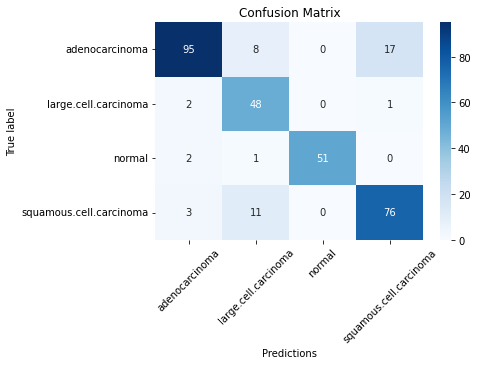

In [22]:
conf_mat = confusion_matrix(true_label,predictions)
sns.heatmap(conf_mat ,fmt='g',annot = True , cmap='Blues' , xticklabels=test_classes , yticklabels = test_classes,)
plt.xlabel('Predictions')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xticks(rotation = 45)
plt.show()

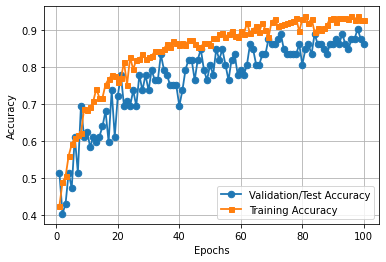

In [23]:
res = results.history
train_acc = res['accuracy']
val_accuracy = res['val_accuracy']
epochs = range(1, len(train_acc) + 1)

line1 = plt.plot(epochs, val_accuracy, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, train_acc, label = 'Training Accuracy')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.5)
plt.setp(line2, linewidth = 1.8, marker = 's', markersize = 5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

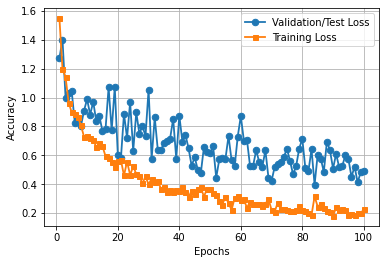

In [24]:
res = results.history
train_loss = res['loss']
val_loss = res['val_loss']
epochs = range(1, len(train_loss) + 1)

line1 = plt.plot(epochs, val_loss, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, train_loss, label = 'Training Loss')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.5)
plt.setp(line2, linewidth = 1.8, marker = 's', markersize = 5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()